<img align="left" src = https://dirac.astro.washington.edu/wp-content/uploads/2022/03/DIRAC_logo-purple-text_transparent-bckg_ALPHA-1-1.png
 width=190 style="padding: 10px">
<br><b>Modeling White Dwarf Color-Magnitude Profiles with Gaia, SDSS and the Combined Montreal and Warwick White Dwarf Databases</b> <br>
Contact author: Bob Abel <br>
Last verified to run: 2023-11-086 <br>
LSST Science Piplines version: Weekly 2023_37 <br>
Container size: medium <br>
Targeted learning level: beginner? <br>
<figcaption align = "left"><b>&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;DiRAC Institute</b></figcaption>


**Objective:**<br>Model DA, DB and DC white dwarf color-magnitude profiles with SDSS photometry and Gaia photogeometric distances.<br>
**Methods:**<br> Data binning, curve-fitting.<br>
**Description:**<br> Color-magnitude models for DA, DB and DC white dwarfs are prepared using two publicly available white dwarf catalogs and Gaia and SDSS data<br>**LSST Data Products:**<br>Dustmaps. <br>**Credits:**<br>Tina Adair, Jennifer Soebeck, Douglas Tucker, Željko Ivezić, Brian Yanny, Allyn Smith, Allan Jackson, literally every single contributing author to the Rubin Stack Club, DP0 Tutorial, and Delegate Contribution Jupyter Notebooks, and Jake Vanderplas.



## <span style="color:blue">Table of Contents</span>
### <span style="color:blue">I. Introduction</span>
### <span style="color:blue">II. Load the combined White Dwarf data set.</span>
<span style="color:blue">From VizieR, we have [Gaia data with geometric and photogeometric distances](https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/MNRAS/508/3877/maincat) at https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/MNRAS/508/3877/maincat. We have White Dwarfs from the [Montreal White Dwarf Database](https://www.montrealwhitedwarfdatabase.org/) and from the Warwick catalog (Fusillo et al. 2021).</span>
### <span style="color:blue">III. Reduce the Data Set</span>
<span style="color:blue">The data has been pre-filtered in acquireWDs.ipynb, we need to account for extinction and calculate absolute magnitudes</span>
### <span style="color:blue">IV. Model White Dwarf DA, DB and DC colors</span>
<span style="color:blue">Bin SDSS colors vs. absolute magnitude and use the median absolute magnitude value in each bin. Fit the result to a polynomial.</span>
### <span style="color:blue">V. Add M Dwarf Data to the Table</span>
<span style="color:blue">This file of M dwarf colors and absolute magnitudes is from Željko.</span>
### <span style="color:blue">VI. Save the File.</span>
<span style="color:blue">WDMD.csv has the processed white dwarf data and will subsequently be used in model_WDMDs.ipynb to calculate $M_{r}$ and colors for White Dwarf/M Dwarf binary systems.</span>


### <span style="color:blue">I. Introduction</span>
<span style="color:blue">The largely hydrogen atmospheres and lack of fusion-related fluctuations make DA white dwarf stars good candidates as photometric distance candles. The Montreal White Dwarf Database contains thousands of objects with identified white dwarf subclasses, including the predominant DA variety. The Warwick database has fewer entries (still in the thousands), and a few are not in the Montreal database, so I've combined them. This database is merged with a Gaia DR3 database containing photogeometric and geometric distances, $T_{eff}$, log(g) and their SDSS magnitudes in each of the u, g, r, i and z filters. Our primary goal is to model the color-magnitude profile of DA, DB, and DC white dwarfs for the SDSS u-g, g-r, r-i and i-z colors. The output file is 301 rows, but you can use the polynomial coefficients calculated to make them any length.</span>

In [1]:
# import modules

import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib as mpl

# Import extinction maps from the Rubin Pipeline
from dustmaps.sfd import SFDQuery


Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/dustmaps_cachedata/gbb0a0c949e+81bc2a20b4/config/.dustmapsrc


### <span style="color:blue">II. Get White Dwarfs</span>
<span style="color:blue"> After filtering, the Montreal White Dwarf Database had 5643, 658 and 378 DA, DB and DC candidates, respectively, while the white dwarf database described by Fusillo et al. 2021 and residing at Warwick University had 2255, 188, 116 DA, DB and DC candidates, respectively. Combining the catalogs and removing duplicates (in acquire_WDs.ipynb), resulted in 5870, 702 and 505 DA, DB and DC candidates, respectively, a 4.0%, 6.8% and 33.6% increase over the Montreal catalog for each class of white dwarfs.</span>

In [2]:
# Read in the white dwarf table (the output file from acquire_WDs.ipynb.
df_GSMWWD = pd.read_csv('MontWarWDs.csv', low_memory=False)


### <span style="color:blue">III. Data Reduction </span>
<span style="color:blue"> Correct the magnitudes for extinction and calculate colors and absolute magnitude.
    

#### <span style="color:blue">Correct the Rubin magnitudes for extinction (from [Jeff Carlin's contributed notebook](https://github.com/rubin-dp0/delegate-contributions-dp02/blob/main/MWhalo_density/Milky_Way_halo_density.ipynb))</span> 
##### <span style="color:blue">Look up the reddening values, E(B-V), from the maps of [Schlegel, Finkbeiner, & Davis (1998)](https://ui.adsabs.harvard.edu/abs/1998ApJ...500..525S/abstract) using the dustmaps package.  Convert them to per-band extinction values using the coefficients derived for DC2 in this [notebook by Sam Schmidt](https://github.com/LSSTDESC/DC2-analysis/blob/master/contributed/Derive_A_EBV_coefficients.ipynb) (see also this [demo](https://github.com/LSSTDESC/DC2-analysis/blob/master/contributed/DC2_object_deredden.ipynb) showing how to apply the corrections). The A_lambda/E(B-V) coefficients for the LSST u, g, r, u, z and y filters are 4.81, 3.64, 2.70, 2.06, 1.58 and 1.31, respectively. I should be using the SDSS values.</span>

In [3]:
# set the A_lamba/E(B-V) values for the six ugrizy LSST filters (what are the values for SDSS?)
# For LSST [u, g, r, i, z, y]: 
# band_a_ebv = np.array([4.81, 3.64, 2.70, 2.06, 1.58, 1.31])
# but for SDSS [u, g, r, i, z]:
band_a_ebv = [5.155, 3.793, 2.751, 2.086, 1.479]

# SFD maps are a function of ra and dec:
coord = SkyCoord(ra=df_GSMWWD['RA_ICRS'], dec=df_GSMWWD['DE_ICRS'], unit='deg')

sfd = SFDQuery()
ebvvec = sfd(coord)
df_GSMWWD['ebv'] = ebvvec

df_GSMWWD['dered_u'] = df_GSMWWD['umag'] - df_GSMWWD['ebv']*band_a_ebv[0]
df_GSMWWD['dered_g'] = df_GSMWWD['gmag'] - df_GSMWWD['ebv']*band_a_ebv[1]
df_GSMWWD['dered_r'] = df_GSMWWD['rmag'] - df_GSMWWD['ebv']*band_a_ebv[2]
df_GSMWWD['dered_i'] = df_GSMWWD['imag'] - df_GSMWWD['ebv']*band_a_ebv[3]
df_GSMWWD['dered_z'] = df_GSMWWD['zmag'] - df_GSMWWD['ebv']*band_a_ebv[4]


#### <span style="color:blue"> Calculate de-reddened colors. </span>

In [4]:
# Calculate some colors
df_GSMWWD['ug'] = df_GSMWWD['dered_u'] - df_GSMWWD['dered_g']
df_GSMWWD['gr'] = df_GSMWWD['dered_g'] - df_GSMWWD['dered_r']
df_GSMWWD['ri'] = df_GSMWWD['dered_r'] - df_GSMWWD['dered_i']
df_GSMWWD['iz'] = df_GSMWWD['dered_i'] - df_GSMWWD['dered_z']
df_GSMWWD['gi'] = df_GSMWWD['dered_g'] - df_GSMWWD['dered_i']
df_GSMWWD['rz'] = df_GSMWWD['dered_r'] - df_GSMWWD['dered_z']


####  <span style="color:blue">Calculate absolute magnitudes: M = m - 5*$log_{10}$(d) + 5 </span>

In [5]:
# Calculate absolute magnitudes: M = m - 5*log10(d) + 5
df_GSMWWD['u_MagAbs'] = df_GSMWWD['dered_u'] - 5. * np.log10(df_GSMWWD['rpgeo']) + 5
df_GSMWWD['g_MagAbs'] = df_GSMWWD['dered_g'] - 5. * np.log10(df_GSMWWD['rpgeo']) + 5
df_GSMWWD['r_MagAbs'] = df_GSMWWD['dered_r'] - 5. * np.log10(df_GSMWWD['rpgeo']) + 5
df_GSMWWD['i_MagAbs'] = df_GSMWWD['dered_i'] - 5. * np.log10(df_GSMWWD['rpgeo']) + 5
df_GSMWWD['z_MagAbs'] = df_GSMWWD['dered_z'] - 5. * np.log10(df_GSMWWD['rpgeo']) + 5

print('Range of (unextincted) absolute magnitudes: ')
print('%2.2f < Abs u Mag < %2.2f' %(np.min(df_GSMWWD['u_MagAbs']), np.max(df_GSMWWD['u_MagAbs'])))
print('%2.2f < Abs g Mag < %2.2f' %(np.min(df_GSMWWD['g_MagAbs']), np.max(df_GSMWWD['g_MagAbs'])))
print('%2.2f < Abs r Mag < %2.2f' %(np.min(df_GSMWWD['r_MagAbs']), np.max(df_GSMWWD['r_MagAbs'])))
print('%2.2f < Abs i Mag < %2.2f' %(np.min(df_GSMWWD['i_MagAbs']), np.max(df_GSMWWD['i_MagAbs'])))
print('%2.2f < Abs z Mag < %2.2f' %(np.min(df_GSMWWD['z_MagAbs']), np.max(df_GSMWWD['z_MagAbs'])))
print(' ')


Range of (unextincted) absolute magnitudes: 
4.52 < Abs u Mag < 16.97
6.09 < Abs g Mag < 15.77
7.64 < Abs r Mag < 15.29
8.08 < Abs i Mag < 15.51
8.36 < Abs z Mag < 16.11
 


In [6]:
# Reduced magnitude, Gaia colors, Gaia absolute g magnitude and the parallax 
# distance are calculated like this, but we don't need them.

# H is the reduced proper motion
# df_GSMWWD['H'] = df_GSMWWD['dered_r'] + 5 * np.log10(df_GSMWWD['PM']/1000.) + 5

# Calculate Gaia colors and absolute Gmag.
# df_GSMWWD['BPminusRP'] = df_GSMWWD['BPmag'] - df_GSMWWD['RPmag']
# df_GSMWWD['Gmag_abs'] = df_GSMWWD['Gmag'] - 5. * np.log10(df_GSMWWD['rpgeo']) + 5

# Compare values for 1/parallax and the geometric and photogeometric values.
# df_GSMWWD['inv_parallax'] = 1. / df_GSMWWD['Plx'] * 1000


### <span style="color:blue">IV. Model white dwarf $M_{r}$ and colors. </span>
<span style="color:blue"> Separate each of the 12 color-Mag plots into color bins. The number of bins depends on each sample. Find the median value of $M_{r}$ for each bin and model the result with a polynomial function, whose degree depends on which is the best fit. </span>


#### <span style="color:blue">What types of white dwarfs are included and how many of each are there? DA's are obviously predominant, but DB and DC are worth consideration. DA's, DB's and DC's </span>

In [7]:
# Create pandas tables for DA, DB and DC white dwarfs.

df_DA = df_GSMWWD[df_GSMWWD['spectype'] == 'DA']
df_DB = df_GSMWWD[df_GSMWWD['spectype'] == 'DB']
df_DC = df_GSMWWD[df_GSMWWD['spectype'] == 'DC']

print('Number of White Dwarfs in Each Stellar Class')
print(' DA   DB  DC')
print(len(df_DA), len(df_DB), len(df_DC))


Number of White Dwarfs in Each Stellar Class
 DA   DB  DC
5870 702 505


#### <span style='color:blue'> Add some functions for modeling the data and evaluating its effectiveness. Bin the data from the medians. Some of these are direct from Željko.</span>

In [8]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 

def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin) 
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux = y[(x>xEdge[i])&(x<=xEdge[i+1])]
        if (yAux.size > 0):
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux)
            # robust estimate of standard deviation: 0.741*(q75-q25)
            sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])
        else:
            nPts[i] = 0 
            medianBin[i] = 0 
            sigGbin[i] = 0 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin

In [9]:
from scipy import stats
from scipy import optimize

# this function computes polynomial models given some data x
# and parameters theta
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, x, y, sigma_y, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(degree, x, y, sigma_y, model=polynomial_fit):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, x, y, sigma_y, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

In [10]:
def bestFitPlot(xBin, medianBin):
    x = xBin
    sigma_y = 0.1 + 0*x
    y = medianBin 
    # data = np.array([x, y, sigma_y])

    # get best-fit parameters for linear, quadratic and cubic models
    theta1 = best_theta(1, x, y, sigma_y)
    theta2 = best_theta(2, x, y, sigma_y)
    theta3 = best_theta(3, x, y, sigma_y)
    theta4 = best_theta(4, x, y, sigma_y)
    theta5 = best_theta(5, x, y, sigma_y)
    theta6 = best_theta(6, x, y, sigma_y)

    # generate best fit lines on a fine grid 
    xfit = np.linspace(-0.1, 3.1, 1000)
    yfit1 = polynomial_fit(theta1, xfit)
    yfit2 = polynomial_fit(theta2, xfit)
    yfit3 = polynomial_fit(theta3, xfit)
    yfit4 = polynomial_fit(theta4, xfit)
    yfit5 = polynomial_fit(theta5, xfit)
    yfit6 = polynomial_fit(theta6, xfit)


    # plot 
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
    ax.plot(xfit, polynomial_fit(theta1, xfit), label='best linear model')
    ax.plot(xfit, polynomial_fit(theta2, xfit), label='best quadratic model')
    ax.plot(xfit, polynomial_fit(theta3, xfit), label='best cubic model')
    ax.plot(xfit, polynomial_fit(theta4, xfit), label='best 4-th order model')
    ax.plot(xfit, polynomial_fit(theta5, xfit), label='best 5-th order model')
    ax.plot(xfit, polynomial_fit(theta6, xfit), label='best 6-th order model')

    ax.legend(loc='best', fontsize=14)
    ax.set_xlabel('Color')
    ax.set_ylabel('$M_{r}$')
    ax.set_title('Comparison of Polynomial Fits', fontsize=16, color='blue')
    
    return x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6


In [11]:
def calcBestFit(x, y, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6):
    # compute chi2 per degree of freedom: sum{[(y-yfit)/sigma_y]^2} 
    chi21 = np.sum(((y-polynomial_fit(theta1, x))/sigma_y)**2) 
    chi22 = np.sum(((y-polynomial_fit(theta2, x))/sigma_y)**2) 
    chi23 = np.sum(((y-polynomial_fit(theta3, x))/sigma_y)**2) 
    chi24 = np.sum(((y-polynomial_fit(theta4, x))/sigma_y)**2) 
    chi25 = np.sum(((y-polynomial_fit(theta5, x))/sigma_y)**2) 
    chi26 = np.sum(((y-polynomial_fit(theta6, x))/sigma_y)**2) 


    # the number of fitted parameters is 2, 3, 4, 5, 6
    BIC1 = chi21 + 2*np.log(nBins)
    BIC2 = chi22 + 3*np.log(nBins)
    BIC3 = chi23 + 4*np.log(nBins)
    BIC4 = chi24 + 5*np.log(nBins)
    BIC5 = chi25 + 6*np.log(nBins)
    BIC6 = chi26 + 7*np.log(nBins)


    print ("         MODEL             CHI2          BIC")
    print ('    best linear model:', chi21, BIC1)
    print (' best quadratic model:', chi22, BIC2)
    print ('     best cubic model:', chi23, BIC3)
    print ('best 4-th order model:', chi24, BIC4)
    print ('best 5-th order model:', chi25, BIC5)
    print ('best 6-th order model:', chi26, BIC6)

In [12]:
def optimizeDist(color, mag, xMin, xMax, nBins):
    # xMin and xMax are generally lower and higher than the bulk of the data, so input
    # them into the object manually.
    xBin, nPts, medianBin, sigGbin = fitMedians(color, mag, xMin, 
                                                xMax, nBins, verbose=0)

    # where Nbin is about 8, that is, the color step is 0.1 mag (though 0.05 mag would be
    # better if the sample allows it).
    # The main purpose of this step is to avoid outliers having an impact on the final fit (median
    # is a robust estimator, unlike mean).

    print('xBins  ', 'medianBin  ', 'SigmaGBin', '    # Pts.  ')
    for i in range(nBins):
        print('%2.3f      %2.2f        %2.2f    %8d' %(xBin[i], medianBin[i], sigGbin[i], nPts[i]))
    
    plt.scatter(xBin, medianBin, label='median bin')
    plt.scatter(xBin, sigGbin, color='red', label='sigB bin')
    plt.xlabel('xBin')
    plt.legend(loc='center left')
    plt.gca().invert_yaxis()
    plt.xlabel('color bin')
    plt.ylabel('Absolute r Magnitude')
    plt.title('Binned Medians Given a Color Range and the Number of Bins', fontsize=16, color='blue')

    return xBin, medianBin, sigGbin

#### <span style="color:blue"> Create a list of absolute magnitude values from 8.50 to 14.50 in 0.02 magnitude increments </span>

In [13]:
Mr = [8.50]
delta_M = 0.02
for i in range(300):
   Mr.append(Mr[i] + delta_M)

print('%.2f ≤ $M_{r} ≤ %.2f' %(Mr[0], Mr[300]))

8.50 ≤ $M_{r} ≤ 14.50


#### <span style="color:blue"> Bin SDSS colors vs. absolute magnitude and use the median value. Evaluate the fits.</span>

#### <span style='color:blue'> III.1a DA for u - g

In [14]:
# Find the maximum range of the data (which will be trimmed down once you get a look at the data).
xMin = np.min(df_DA['ug'])
xMax = np.max(df_DA['ug'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -1.740, 2.982


xBins   medianBin   SigmaGBin     # Pts.  
-0.173      10.39        0.03         101
-0.138      10.39        0.03         117
-0.104      10.55        0.02         157
-0.069      10.61        0.02         146
-0.035      10.68        0.02         164
-0.000      10.81        0.02         179
0.034      10.91        0.02         184
0.069      10.92        0.02         231
0.103      11.01        0.02         202
0.138      11.05        0.02         213
0.172      11.15        0.02         233
0.207      11.24        0.02         250
0.241      11.30        0.02         284
0.276      11.42        0.04         276
0.310      11.66        0.06         315
0.345      12.03        0.04         487
0.379      12.30        0.03         681
0.414      12.27        0.04         593
0.448      12.36        0.06         379
0.483      12.84        0.09         192


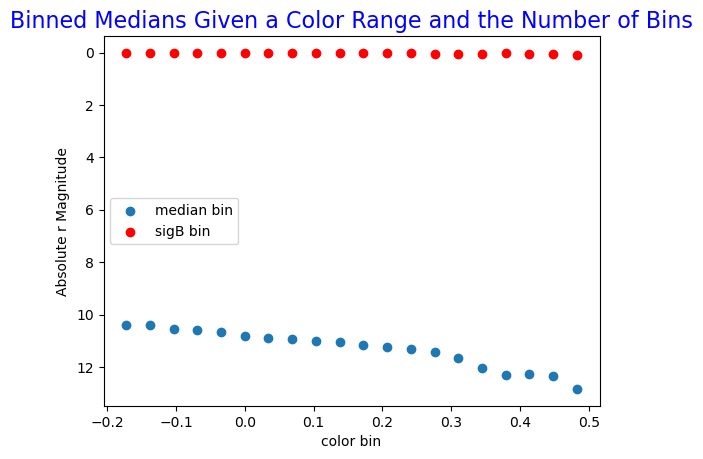

In [15]:
# After looking at the data, we adjust xMin, xMax and nbins.
nBins = 20
xBin, medianBin, sigGbin = optimizeDist(df_DA['ug'], df_DA['r_MagAbs'], xMin=-.19, 
                                       xMax=0.50, nBins=nBins)

         MODEL             CHI2          BIC
    best linear model: 67.74759232508964 73.73905687219762
 best quadratic model: 21.28812527471153 30.275322095373504
     best cubic model: 15.545596241295014 27.528525335510977
best 4-th order model: 14.512956521374003 29.491617889143956
best 5-th order model: 12.879360741423787 30.85375438274773
best 6-th order model: 11.007094764321787 31.977220679199725


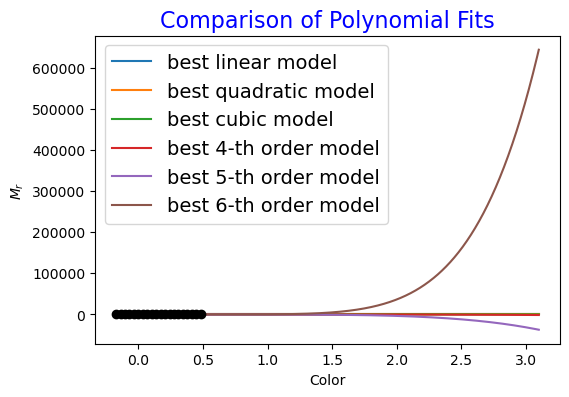

In [16]:
# Calculate the best fit.
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)

Coefficients of the polynomial fit are 8.7849, 0.2370, 2.0856, 10.7620 


Text(0.5, 1.0, 'Polynomial Fit of Degree 3 to Data')

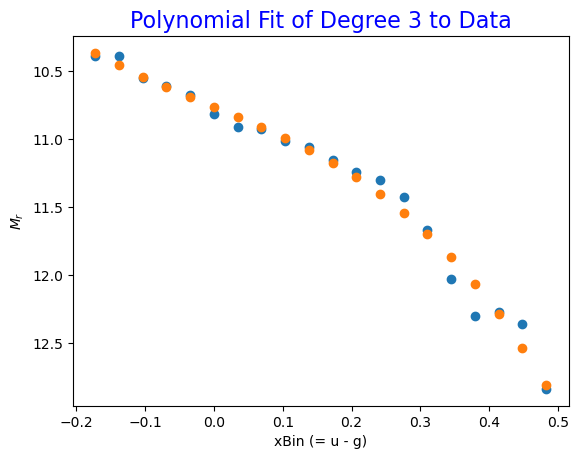

In [17]:
# Find the coefficients that best fit the data, given the polynomial degree,
# and plot the result

degree = 3
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f, %.4f, %.4f ' %(z[0], z[1], z[2], z[3]))

plt.scatter(xBin, medianBin)
y_value = z[0]*xBin**3 + z[1]*xBin**2 + z[2]*xBin + z[3]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= u - g)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


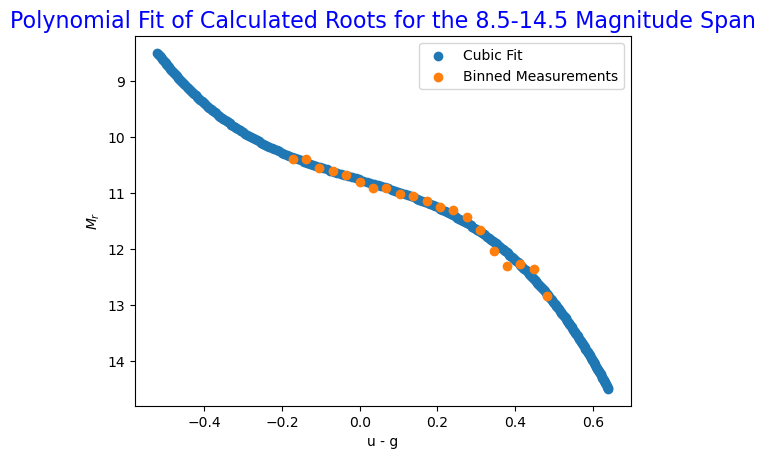

In [18]:
# Calculate the roots of your polynomial fit
DAug_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1], z[2], z[3]- Mr[i]]
#   finding the roots of the cubic equation
    DAug_roots.append(np.roots(z2)[2])

plt.scatter(DAug_roots, Mr, label='Cubic Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('u - g')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Calculated Roots for the 8.5-14.5 Magnitude Span', fontsize=16, color='blue')
plt.legend(loc='upper right')

#### <span style='color:blue'> III.1b DA for g - r

In [19]:
xMin = np.min(df_DA['gr'])
xMax = np.max(df_DA['gr'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -2.188, 3.512


xBins   medianBin   SigmaGBin     # Pts.  
-0.484      10.22        0.05         215
-0.452      10.50        0.02         329
-0.421      10.72        0.02         367
-0.389      10.89        0.01         524
-0.357      11.09        0.01         542
-0.325      11.25        0.01         495
-0.294      11.41        0.01         360
-0.262      11.53        0.02         287
-0.230      11.68        0.02         276
-0.198      11.78        0.03         179
-0.167      11.95        0.04         170
-0.135      12.11        0.02         214
-0.103      12.25        0.02         266
-0.071      12.40        0.02         264
-0.040      12.53        0.02         240
-0.008      12.69        0.02         213
0.024      12.82        0.02         174
0.056      13.00        0.02         167
0.087      13.12        0.03         139
0.119      13.22        0.02         132


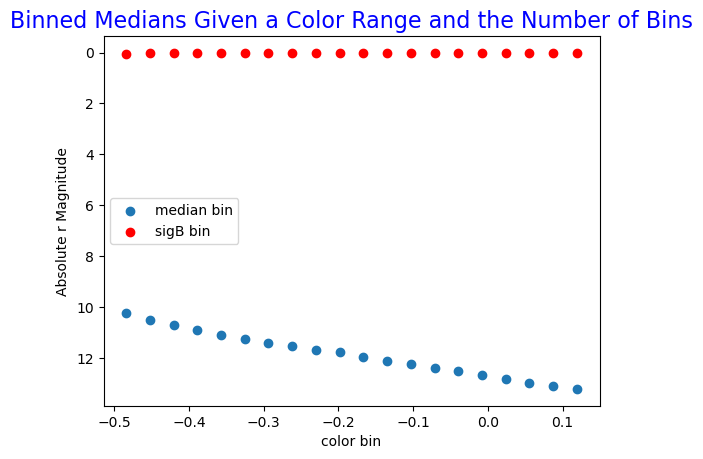

In [20]:
nBins = 20
xBin, medianBin, sigGbin = optimizeDist(df_DA['gr'], df_DA['r_MagAbs'], xMin=-.5, 
                                       xMax=0.135, nBins=nBins)

         MODEL             CHI2          BIC
    best linear model: 7.5558203222733615 13.547284869381343
 best quadratic model: 3.3585063354162425 12.345703156078216
     best cubic model: 1.576374855848722 13.559303950064685
best 4-th order model: 0.2872694539885633 15.265930821758516
best 5-th order model: 0.28579129967148226 18.26018494099543
best 6-th order model: 0.2824679174108808 21.252593832288817


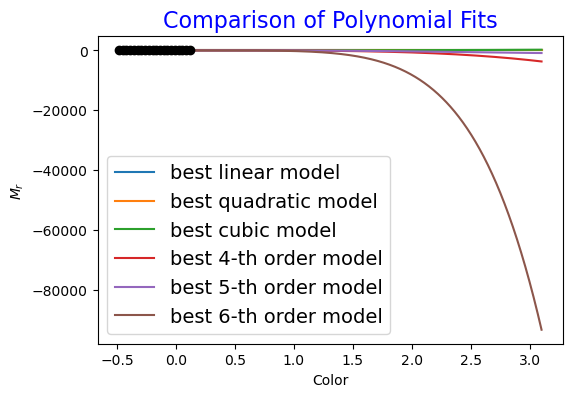

In [21]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are -1.5339, 4.2207, 


Text(0.5, 1.0, 'Polynomial Fit of Degree 2 to Data')

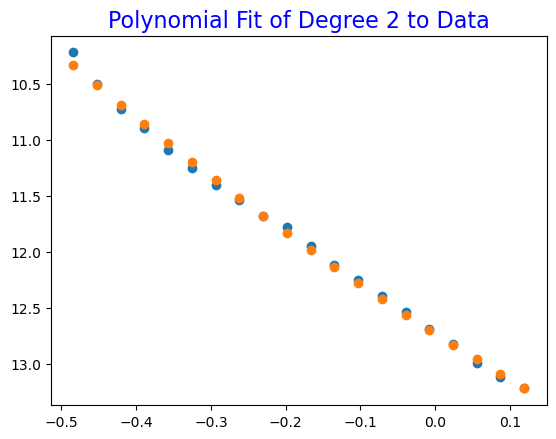

In [22]:
degree = 2
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f, ' %(z[0], z[1]))


plt.scatter(xBin, medianBin)
y_value = z[0]*xBin**2 + z[1]*xBin + z[2]
plt.scatter(xBin, y_value)
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


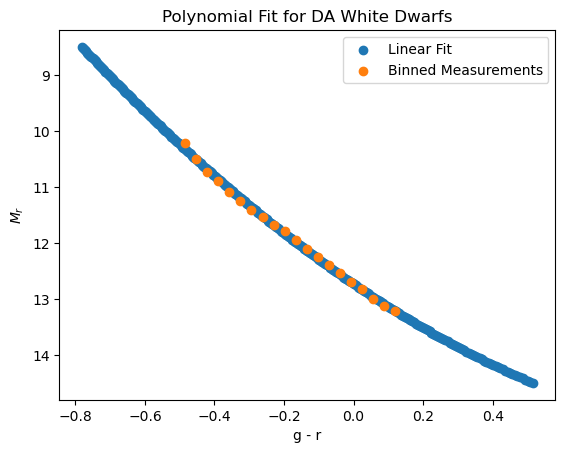

In [23]:
# Calculate the roots of your polynomial fit
DAgr_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1], z[2] - Mr[i]]
#   finding the roots of the cubic equation
    DAgr_roots.append(np.roots(z2)[1])

plt.scatter(DAgr_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('g - r')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DA White Dwarfs')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()


#### <span style='color:blue'> III.1c DA for r - i

In [24]:
xMin = np.min(df_DA['ri'])
xMax = np.max(df_DA['ri'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -2.569, 1.604


xBins   medianBin   SigmaGBin     # Pts.  
-0.361      10.33        0.04         218
-0.342      10.51        0.03         321
-0.324      10.74        0.02         460
-0.305      10.92        0.02         532
-0.287      11.14        0.02         559
-0.268      11.27        0.02         466
-0.250      11.40        0.02         355
-0.231      11.53        0.03         277
-0.213      11.71        0.02         222
-0.194      11.85        0.03         170
-0.176      11.96        0.03         178
-0.157      12.11        0.03         188
-0.139      12.21        0.03         167
-0.120      12.33        0.03         193
-0.102      12.44        0.02         229
-0.083      12.58        0.02         212
-0.065      12.68        0.03         185
-0.046      12.86        0.02         167
-0.028      12.97        0.03         164
-0.009      13.11        0.03         159


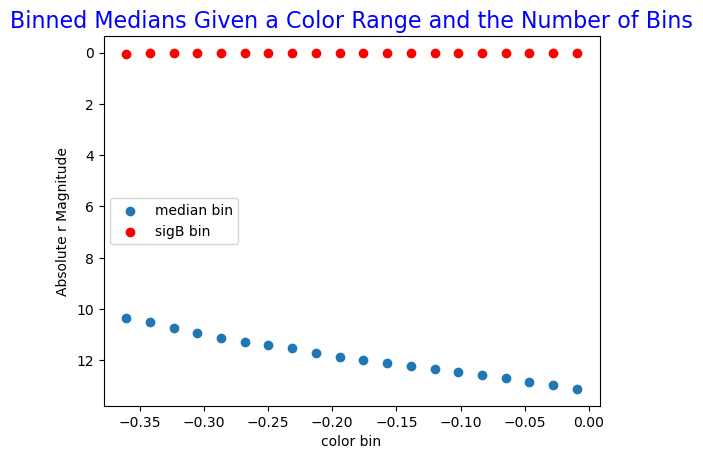

In [25]:
nBins = 20
xBin, medianBin, sigGbin = optimizeDist(df_DA['ri'], df_DA['r_MagAbs'], xMin=-.37, 
                                       xMax=0., nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 10.134953289580507 16.12641783668849
 best quadratic model: 2.723686078907215 11.710882899569189
     best cubic model: 0.6111705788683248 12.594099673084289
best 4-th order model: 0.6086036724892616 15.587265040259215
best 5-th order model: 0.6085643137461452 18.582957955070093
best 6-th order model: 0.6085641336017411 21.57869004847968


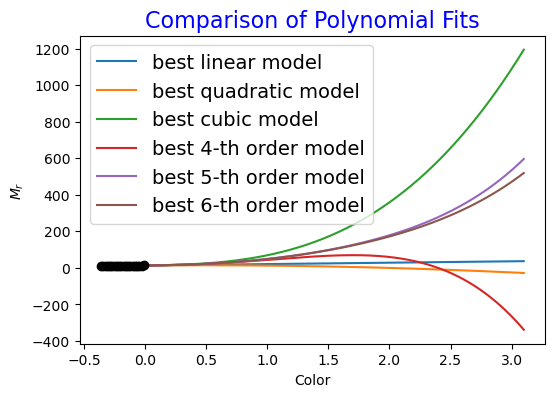

In [26]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are -6.0033, 5.3724, 13.1001       


Text(0.5, 1.0, 'Polynomial Fit of Degree 2 to Data')

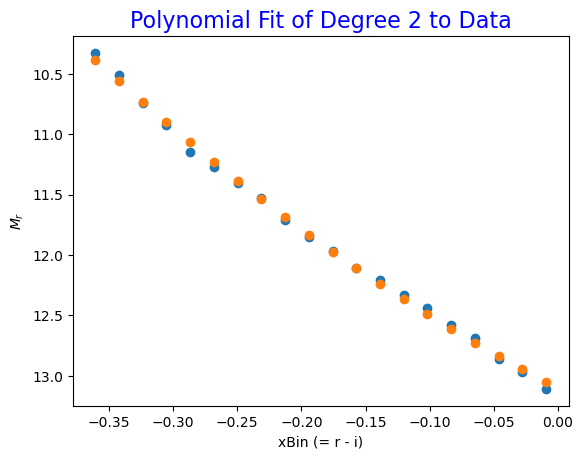

In [27]:
degree = 2
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f, %.4f \
      ' %(z[0], z[1], z[2]))


plt.scatter(xBin, medianBin)
y_value = z[0]*xBin**2 + z[1]*xBin + z[2]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= r - i)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


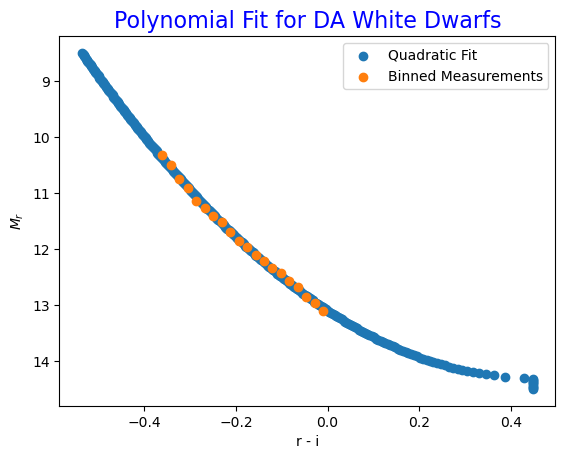

In [28]:
# coefficients of the cubic equation: ax^2 + bx + c = 0
# list of coefficients in descending order of powers
DAri_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1], z[2] - Mr[i]]
#   finding the roots of the cubic equation
    DAri_roots.append(np.roots(z2)[1])

plt.scatter(DAri_roots, Mr, label='Quadratic Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('r - i')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DA White Dwarfs', fontsize=16, color='blue')
plt.gca().invert_yaxis()
plt.legend(loc='upper right')

#### <span style='color:blue'> III.1d DA for i - z

In [29]:
xMin = np.min(df_DA['iz'])
xMax = np.max(df_DA['iz'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -2.067, 1.891


xBins   medianBin   SigmaGBin     # Pts.  
-0.369      10.82        0.05         212
-0.348      10.77        0.04         322
-0.327      10.93        0.03         499
-0.306      11.05        0.03         572
-0.284      11.19        0.03         624
-0.263      11.35        0.03         490
-0.242      11.48        0.04         427
-0.221      11.72        0.04         356
-0.199      12.05        0.05         295
-0.178      12.23        0.04         294
-0.157      12.49        0.04         293
-0.136      12.57        0.04         261
-0.114      12.80        0.04         235
-0.093      12.93        0.04         216
-0.072      13.03        0.05         158
-0.051      13.14        0.06         117


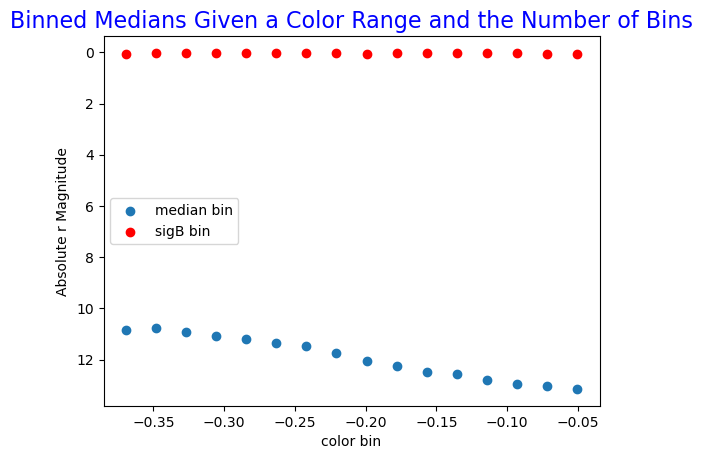

In [30]:
nBins = 16
xBin, medianBin, sigGbin = optimizeDist(df_DA['iz'], df_DA['r_MagAbs'], xMin=-.38, 
                                       xMax=-0.04, nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 17.091128982530037 22.6363064270096
 best quadratic model: 15.86439130574763 24.182157472466972
     best cubic model: 2.5725246453185946 13.66287953427772
best 4-th order model: 2.559922401227002 16.422866012425906
best 5-th order model: 2.3123629744754766 18.947895307914163
best 6-th order model: 2.336434215140815 21.744555270819284


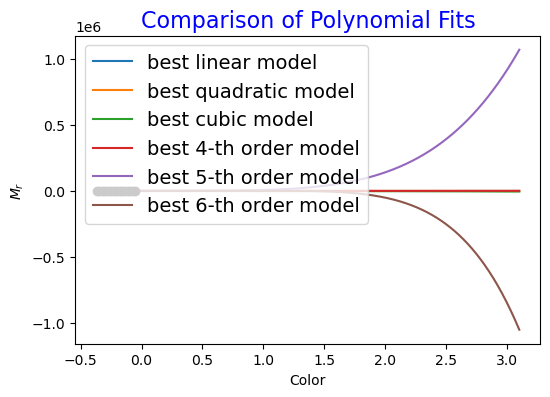

In [31]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are 3.2454, 9.6473, 13.7608       


Text(0.5, 1.0, 'Polynomial Fit of Degree 2 to Data')

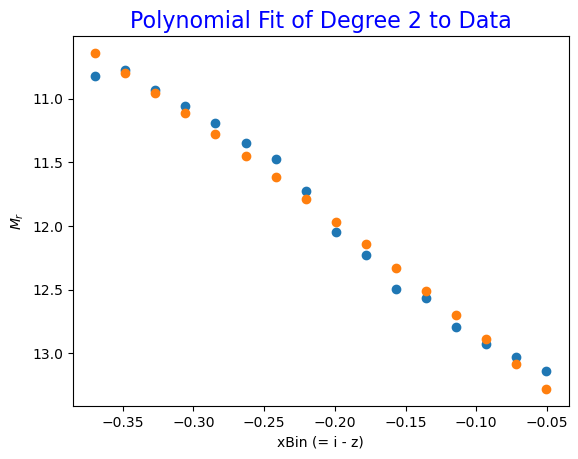

In [32]:
degree = 2
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f, %.4f \
      ' %(z[0], z[1], z[2]))


plt.scatter(xBin, medianBin)
y_value = z[0]*xBin**2 + z[1]*xBin + z[2]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= i - z)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


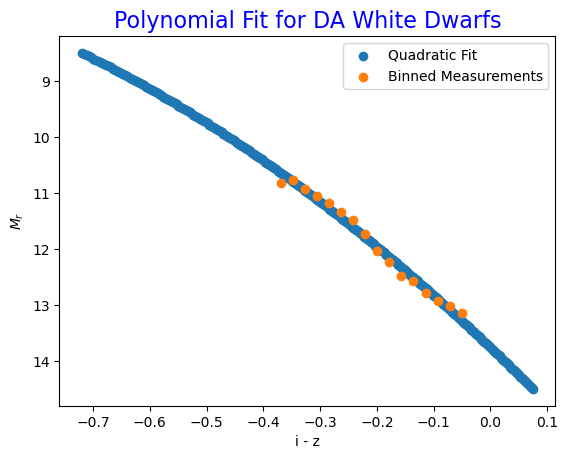

In [33]:
# coefficients of the cubic equation: ax^2 + bx + c = 0
# list of coefficients in descending order of powers
DAiz_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1], z[2] - Mr[i]]
#   finding the roots of the cubic equation
    DAiz_roots.append(np.roots(z2)[1])
#     print(np.roots(z2)[0])

plt.scatter(DAiz_roots, Mr, label='Quadratic Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('i - z')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit for DA White Dwarfs', fontsize=16, color='blue')
plt.legend(loc='upper right')

#### <span style='color:purple'> Median List for DA White Dwarfs is Complete </span>

Text(0.5, 1.0, 'Color Magnitude Fits for DA White Dwarfs')

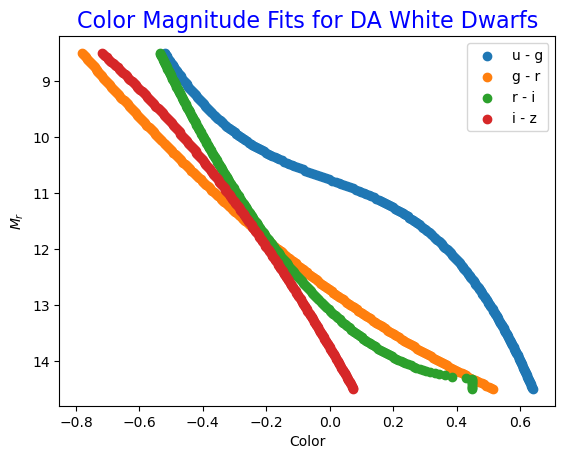

In [34]:
plt.scatter(DAug_roots, Mr, label='u - g')
plt.scatter(DAgr_roots, Mr, label='g - r')
plt.scatter(DAri_roots, Mr, label='r - i')
plt.scatter(DAiz_roots, Mr, label='i - z')
plt.gca().invert_yaxis()
plt.xlabel('Color')
plt.ylabel('$M_{r}$')
plt.legend()
plt.title('Color Magnitude Fits for DA White Dwarfs', fontsize=16, color='blue')

#### <span style='color:blue'> Calculate $M_{r}$ for DB colors

#### <span style='color:green'> III.2a DB for u - g

In [35]:
xMin = np.min(df_DB['ug'])
xMax = np.max(df_DB['ug'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -0.732, 0.325


xBins   medianBin   SigmaGBin     # Pts.  
-0.169      10.98        0.06          56
-0.146      11.04        0.05          67
-0.124      11.14        0.03         110
-0.101      11.20        0.05          88
-0.079      11.43        0.04          86
-0.056      11.55        0.03          58
-0.034      11.67        0.02          37
-0.011      11.77        0.02          49


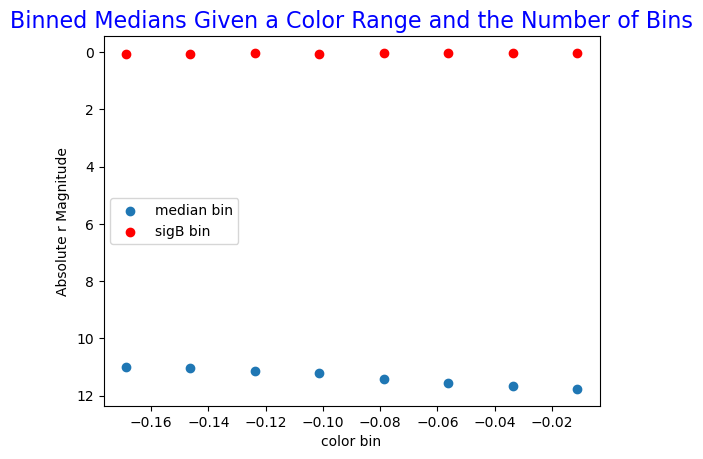

In [36]:
nBins = 8
xBin, medianBin, sigGbin = optimizeDist(df_DB['ug'], df_DB['r_MagAbs'], 
                                        xMin=-.18, xMax=0., nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 1.4295216584977346 5.588404741857406
 best quadratic model: 1.098560891222022 7.336885516261528
     best cubic model: 0.47403506180601085 8.791801228525355
best 4-th order model: 0.44323236357165297 10.840440071970832
best 5-th order model: 0.4780362682582882 12.954685518337302
best 6-th order model: 0.43760921927881413 14.993700011037664


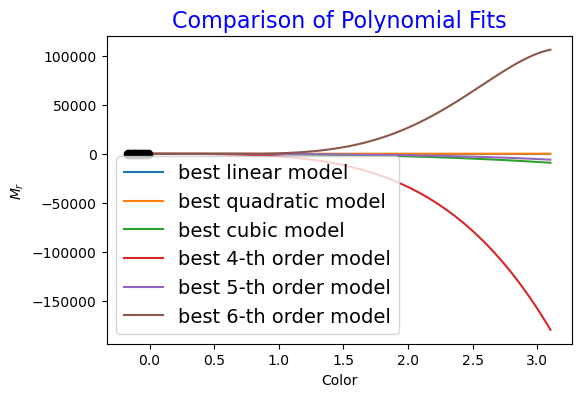

In [37]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are 5.3610, 11.8306 


Text(0.5, 1.0, 'Polynomial Fit of Degree 1 to Data')

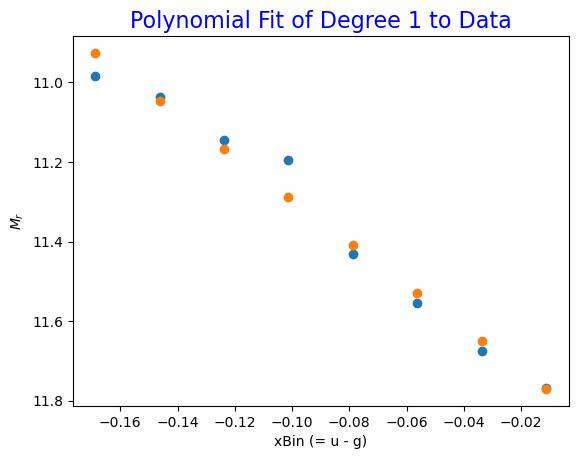

In [38]:
degree = 1
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f ' %(z[0], z[1]))


plt.scatter(xBin, medianBin)
y_value = z[0]*xBin + z[1]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= u - g)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


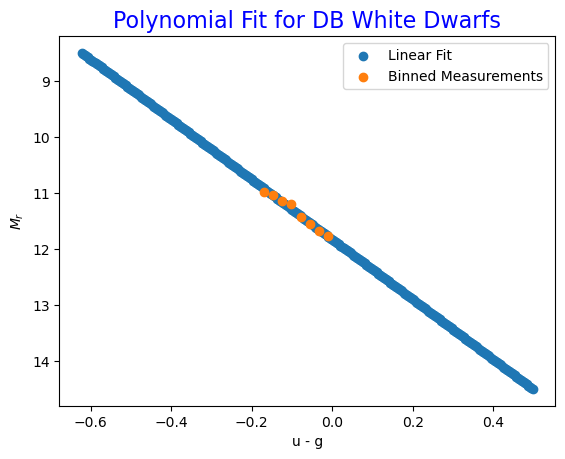

In [39]:
# coefficients of the cubic equation: ax^2 + bx + c = 0
# list of coefficients in descending order of powers
DBug_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1] - Mr[i]]
#   finding the roots of the cubic equation
    DBug_roots.append(np.roots(z2))
#     print(np.roots(z2)[0])

plt.scatter(DBug_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('u - g')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit for DB White Dwarfs', fontsize=16, color='blue')
plt.legend(loc='upper right')

#### <span style='color:green'> III.2b DB for g - r

In [40]:
xMin = np.min(df_DB['gr'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))
print(xMin, xMax)

xMin, xMax = -0.769, 0.325
-0.7688403129577637 0.3246733024716377


xBins   medianBin   SigmaGBin     # Pts.  
-0.402      10.87        0.07          27
-0.390      10.87        0.04          37
-0.379      10.89        0.04          47
-0.367      11.04        0.05          36
-0.355      11.12        0.03          43
-0.343      11.17        0.03          59
-0.332      11.25        0.06          40
-0.320      11.28        0.04          44
-0.308      11.41        0.04          42
-0.296      11.55        0.04          45
-0.285      11.63        0.04          35
-0.273      11.63        0.04          34
-0.261      11.65        0.04          20
-0.249      11.73        0.05          23
-0.238      11.71        0.04          21
-0.226      11.84        0.04          27


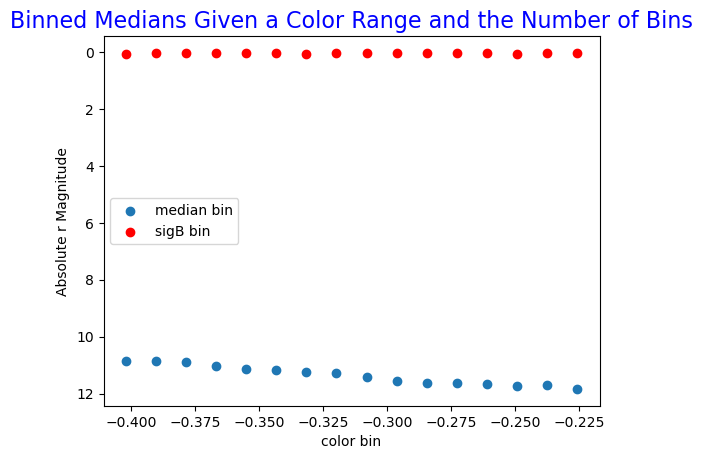

In [41]:
nBins = 16
xBin, medianBin, sigGbin = optimizeDist(df_DB['gr'], df_DB['r_MagAbs'], 
                                        xMin=-.408, xMax=-0.22, nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 4.384011761265038 9.9291892057446
 best quadratic model: 3.498934033643807 11.816700200363151
     best cubic model: 2.45523915606523 13.545594045024355
best 4-th order model: 2.052397114023149 15.915340725222055
best 5-th order model: 2.3941741068288547 19.02970644026754
best 6-th order model: 2.076148822437929 21.484269878116397


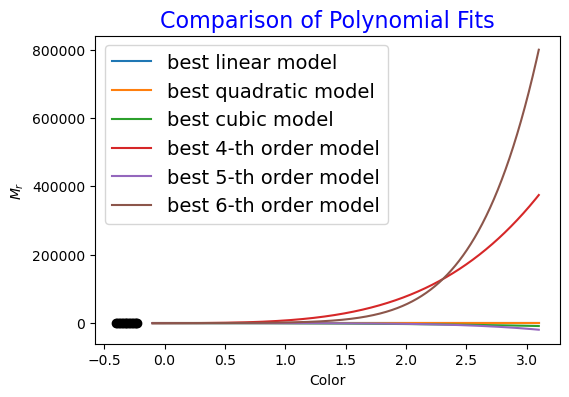

In [42]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are 5.8891, 13.2004 


Text(0.5, 1.0, 'Polynomial Fit of Degree 1 to Data')

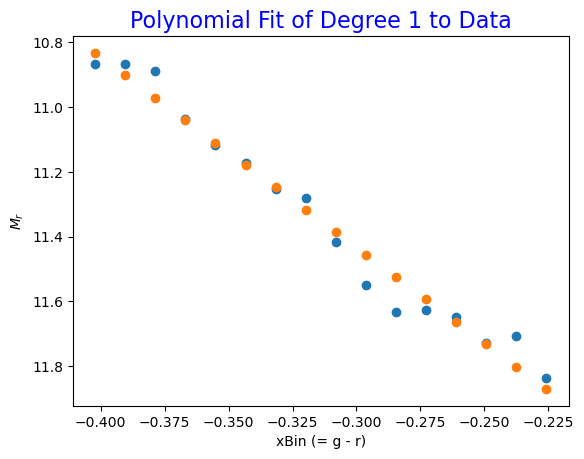

In [43]:
degree = 1
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f ' %(z[0], z[1]))

plt.scatter(xBin, medianBin)
y_value = z[0]*xBin + z[1]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= g - r)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


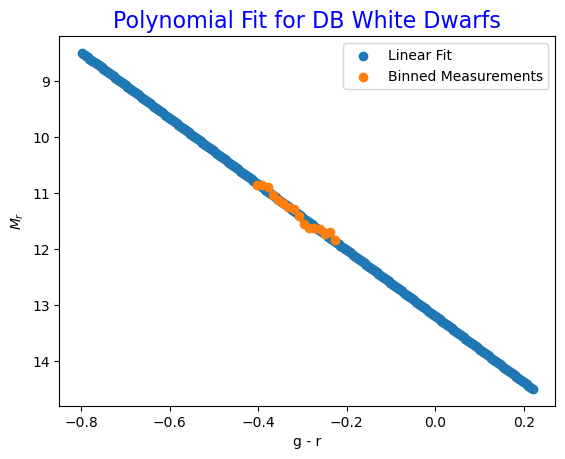

In [44]:
# coefficients of the cubic equation: ax^2 + bx + c = 0
# list of coefficients in descending order of powers
DBgr_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1] - Mr[i]]
#   finding the roots of the cubic equation
    DBgr_roots.append(np.roots(z2))
#     print(np.roots(z2)[0])

plt.scatter(DBgr_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('g - r')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DB White Dwarfs', fontsize=16, color='blue')
plt.gca().invert_yaxis()
plt.legend(loc='upper right')

#### <span style='color:green'> III.2c DB for r - i

In [45]:
xMin = np.min(df_DB['ri'])
xMax = np.max(df_DB['ri'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -1.484, 0.030


xBins   medianBin   SigmaGBin     # Pts.  
-0.307      10.85        0.05          49
-0.292      11.01        0.03          77
-0.278      11.12        0.04          74
-0.263      11.23        0.03         112
-0.247      11.33        0.03          77
-0.232      11.61        0.03          72
-0.218      11.64        0.03          63
-0.203      11.77        0.04          40


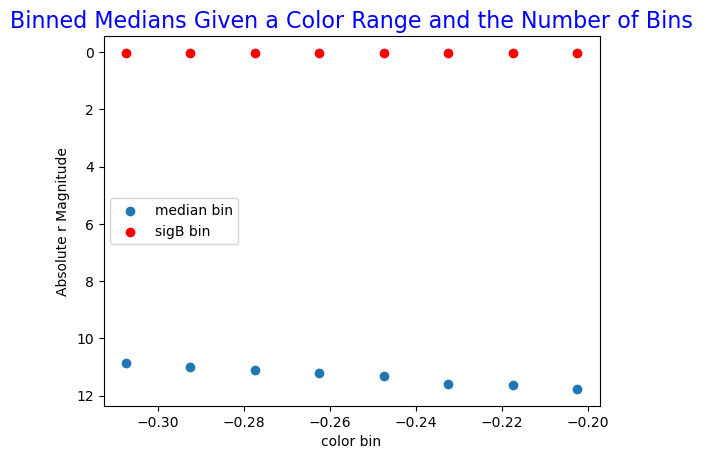

In [46]:
nBins = 8
xBin, medianBin, sigGbin = optimizeDist(df_DB['ri'], df_DB['r_MagAbs'], 
                                        xMin=-.315, xMax=-0.195, nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 1.3648812141374447 5.523764297497117
 best quadratic model: 1.3648535468876255 7.603178171927132
     best cubic model: 1.279283760051275 9.597049926770618
best 4-th order model: 1.2841482941237246 11.681356002522904
best 5-th order model: 1.2866301044538009 13.763279354532814
best 6-th order model: 1.2875435180320587 15.84363430979091


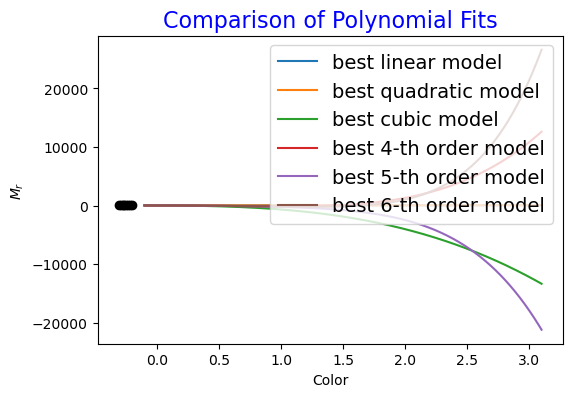

In [47]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are 8.8759, 13.5832 


Text(0.5, 1.0, 'Polynomial Fit of Degree 1 to Data')

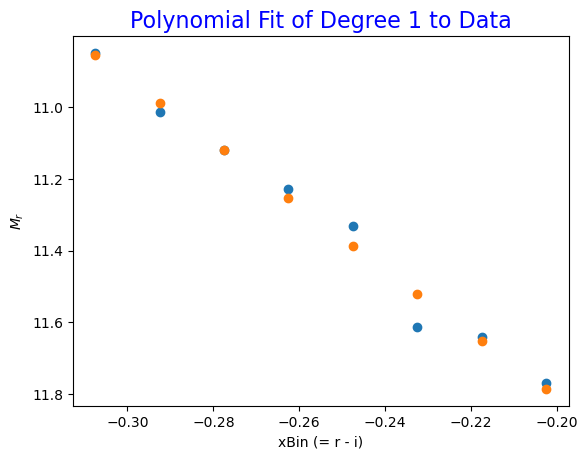

In [48]:
degree = 1
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f ' %(z[0], z[1]))

plt.scatter(xBin, medianBin)
y_value = z[0]*xBin + z[1]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= r - i)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


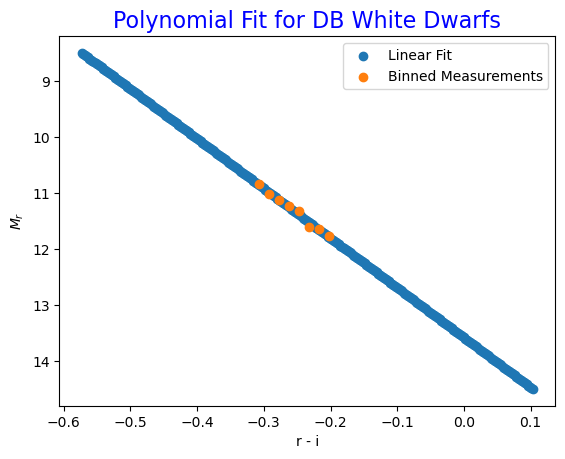

In [49]:
# coefficients of the cubic equation: ax^2 + bx + c = 0
# list of coefficients in descending order of powers
DBri_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1] - Mr[i]]
#   finding the roots of the cubic equation
    DBri_roots.append(np.roots(z2))
#     print(np.roots(z2)[0])

plt.scatter(DBri_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('r - i')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DB White Dwarfs', fontsize=16, color='blue')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()

#### <span style='color:green'> III.2d DB for i - z

In [50]:
xMin = np.min(df_DB['iz'])
xMax = np.max(df_DB['iz'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -0.621, 0.894


xBins   medianBin   SigmaGBin     # Pts.  
-0.323      11.04        0.08          33
-0.309      11.14        0.07          61
-0.296      11.11        0.07          56
-0.282      11.20        0.07          64
-0.268      11.26        0.07          80
-0.254      11.33        0.07          60
-0.241      11.45        0.07          66
-0.227      11.51        0.07          42


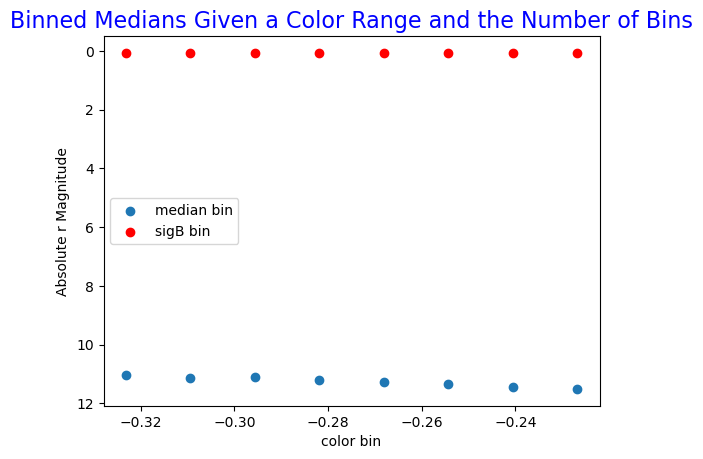

In [51]:
nBins = 8
xBin, medianBin, sigGbin = optimizeDist(df_DB['iz'], df_DB['r_MagAbs'], 
                                        xMin=-.33, xMax=-0.22, nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 0.8587331315914912 5.017616214951163
 best quadratic model: 0.48192727126218626 6.7202518963016935
     best cubic model: 0.4818695124225578 8.7996356791419
best 4-th order model: 0.48200585361922715 10.879213562018407
best 5-th order model: 0.4815968005455107 12.958246050624524
best 6-th order model: 0.4814630638539203 15.03755385561277


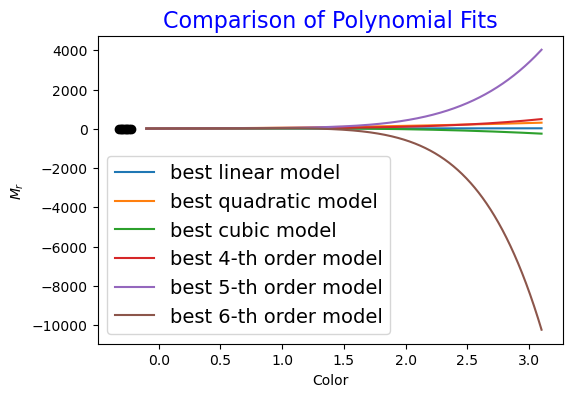

In [52]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are  4.8304, 12.5816 


Text(0.5, 1.0, 'Polynomial Fit of Degree 1 to Data')

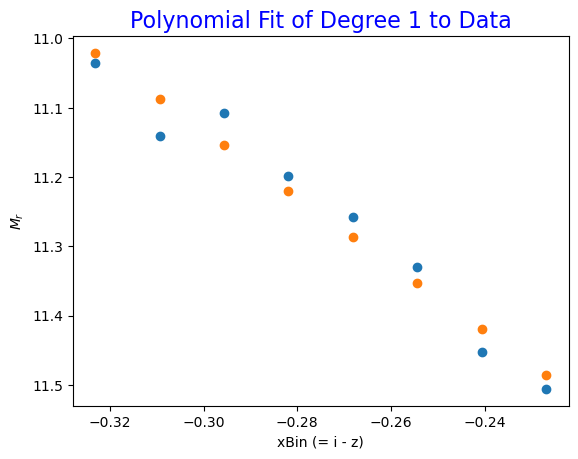

In [53]:
degree = 1
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are  %.4f, %.4f ' %(z[0], z[1]))

plt.scatter(xBin, medianBin)
y_value = z[0]*xBin + z[1]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= i - z)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


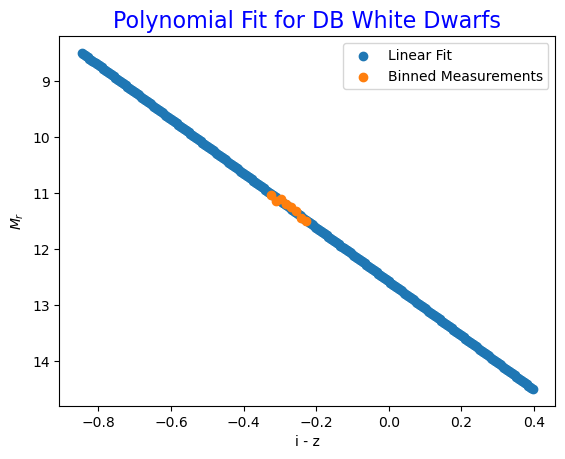

In [54]:
# coefficients of the cubic equation: ax^2 + bx + c = 0
# list of coefficients in descending order of powers
DBiz_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1] - Mr[i]]
#   finding the roots of the cubic equation
    DBiz_roots.append(np.roots(z2))
#     print(np.roots(z2)[0])

plt.scatter(DBiz_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('i - z')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DB White Dwarfs', fontsize=16, color='blue')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()

Text(0.5, 1.0, 'Color Magnitude Fits for DB White Dwarfs')

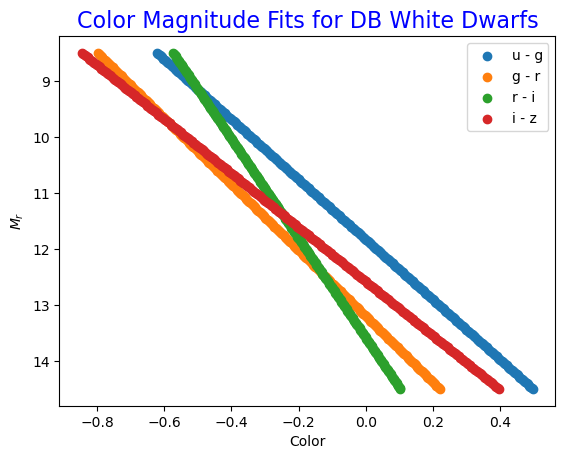

In [55]:
# Plot all colors together (with Mag)

plt.scatter(DBug_roots, Mr, label='u - g')
plt.scatter(DBgr_roots, Mr, label='g - r')
plt.scatter(DBri_roots, Mr, label='r - i')
plt.scatter(DBiz_roots, Mr, label='i - z')
plt.gca().invert_yaxis()
plt.xlabel('Color')
plt.ylabel('$M_{r}$')
plt.legend()
plt.title('Color Magnitude Fits for DB White Dwarfs', fontsize=16, color='blue')

### <span style='color:green'> DC White Dwarfs </span>

#### <span style='color:green'>III.3a DC for u - g

In [56]:
xMin = np.min(df_DC['ug'])
xMax = np.max(df_DC['ug'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -0.499, 1.198


xBins   medianBin   SigmaGBin     # Pts.  
0.077      12.30        0.04          57
0.131      12.48        0.04          61
0.184      12.78        0.05          57
0.238      12.95        0.05          47
0.292      13.14        0.04          44
0.346      13.34        0.04          50
0.399      13.40        0.04          46
0.453      13.56        0.04          42


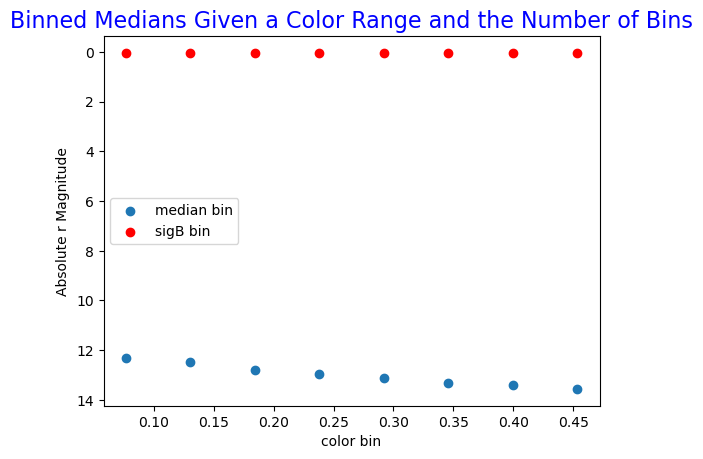

In [57]:
nBins = 8
xBin, medianBin, sigGbin = optimizeDist(df_DC['ug'], df_DC['r_MagAbs'], 
                                        xMin=0.05, xMax=0.48, nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 2.7662291093162104 6.925112192675882
 best quadratic model: 0.6926161313055917 6.930940756345098
     best cubic model: 0.6697249313338892 8.987491098053232
best 4-th order model: 0.4903138181272855 10.887521526526465
best 5-th order model: 0.4915841240588734 12.968233374137887
best 6-th order model: 0.49144324989799143 15.04753404165684


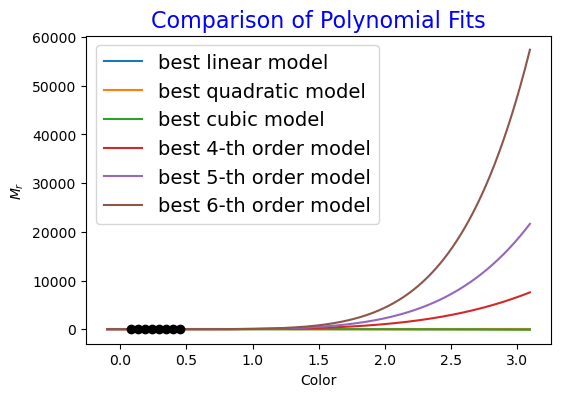

In [58]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are 3.3728, 12.0997 


Text(0.5, 1.0, 'Polynomial Fit of Degree 1 to Data')

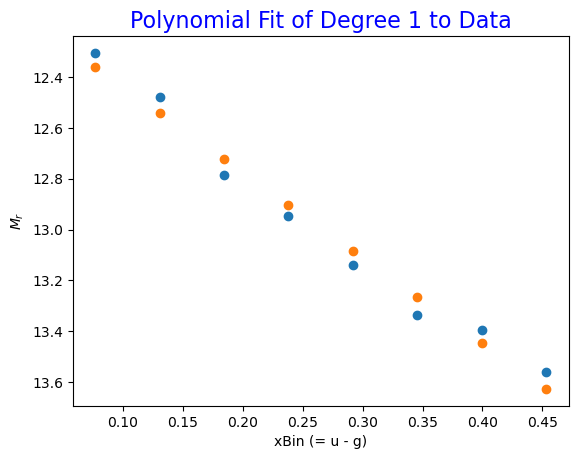

In [59]:
degree = 1
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f ' %(z[0], z[1]))

plt.scatter(xBin, medianBin)
y_value = z[0]*xBin + z[1]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= u - g)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


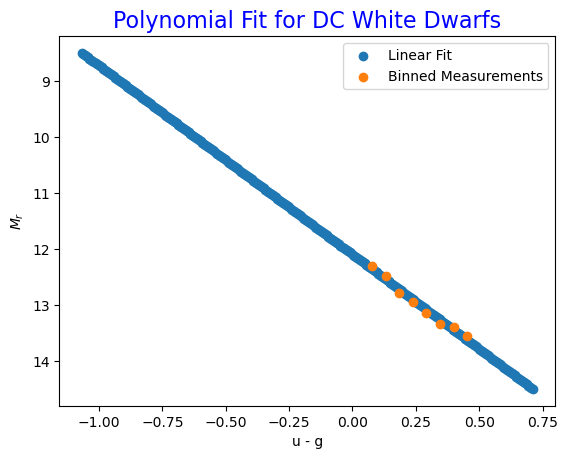

In [60]:

# list of coefficients in descending order of powers
DCug_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1] - Mr[i]]
#   finding the roots of the cubic equation
    DCug_roots.append(np.roots(z2))
#     print(np.roots(z2)[0])

plt.scatter(DCug_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('u - g')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DC White Dwarfs', fontsize=16, color='blue')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()

#### <span style='color:green'>III.3b DC for g - r

In [61]:
xMin = np.min(df_DC['gr'])
xMax = np.max(df_DC['gr'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -0.598, 0.486


xBins   medianBin   SigmaGBin     # Pts.  
-0.196      12.19        0.04          45
-0.147      12.38        0.03          65
-0.098      12.69        0.04          70
-0.049      12.84        0.04          53
-0.001      13.15        0.05          55
0.048      13.31        0.02          67
0.097      13.45        0.04          58
0.146      13.63        0.04          38


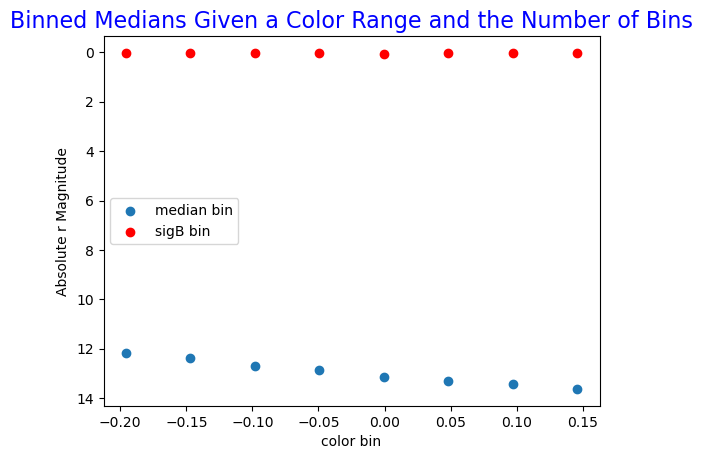

In [62]:
nBins = 8
xBin, medianBin, sigGbin = optimizeDist(df_DC['gr'], df_DC['r_MagAbs'], 
                                        xMin=-0.22, xMax=0.17, nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 2.2228890641226373 6.381772147482309
 best quadratic model: 0.8946166851329111 7.132941310172418
     best cubic model: 0.8003963533294574 9.1181625200488
best 4-th order model: 0.6733540716451472 11.070561780044326
best 5-th order model: 0.6472496372580261 13.12389888733704
best 6-th order model: 0.6741215717624304 15.23021236352128


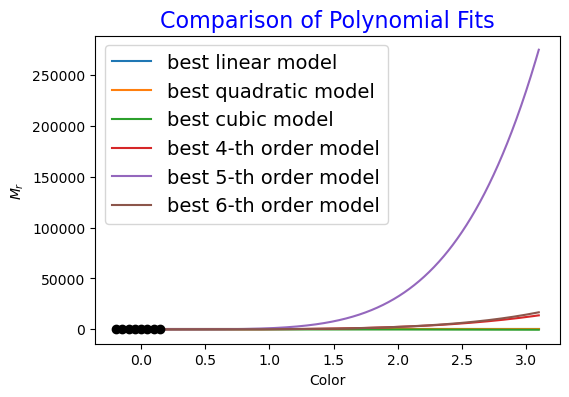

In [63]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are 4.2966, 13.0632 


Text(0.5, 1.0, 'Polynomial Fit of Degree 1 to Data')

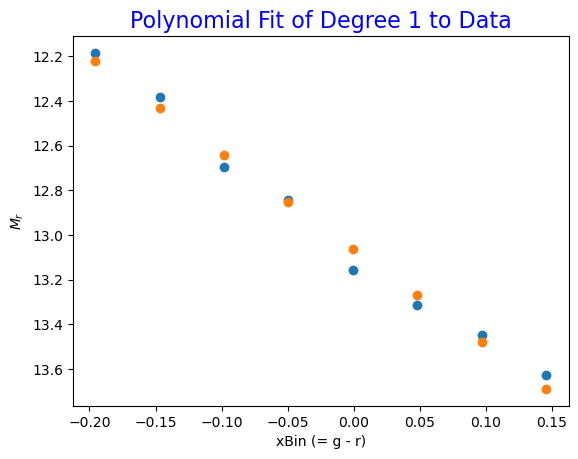

In [64]:
degree = 1
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f ' %(z[0], z[1]))

plt.scatter(xBin, medianBin)
y_value = z[0]*xBin + z[1]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= g - r)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


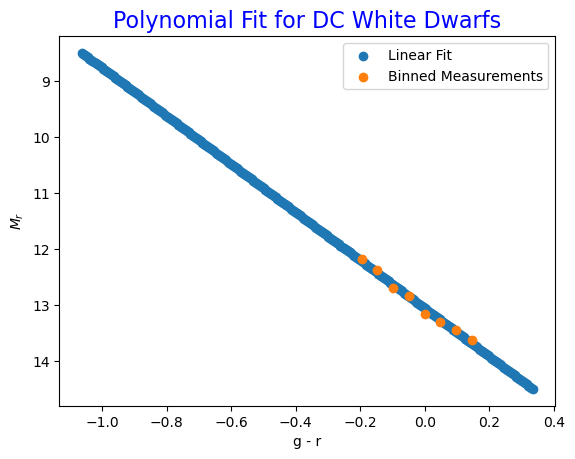

In [65]:
# list of coefficients in descending order of powers
DCgr_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1] - Mr[i]]
#   finding the roots of the cubic equation
    DCgr_roots.append(np.roots(z2))
#     print(np.roots(z2)[0])

plt.scatter(DCgr_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('g - r')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DC White Dwarfs', fontsize=16, color='blue')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()


#### <span style='color:green'> III.3c DC for r - i

In [66]:
xMin = np.min(df_DC['ri'])
xMax = np.max(df_DC['ri'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -0.489, 0.272


xBins   medianBin   SigmaGBin     # Pts.  
-0.186      12.27        0.03          53
-0.159      12.48        0.04          67
-0.131      12.76        0.04          56
-0.104      12.97        0.05          51
-0.076      13.18        0.04          61
-0.049      13.38        0.03          52
-0.021      13.47        0.05          50
0.006      13.61        0.04          47


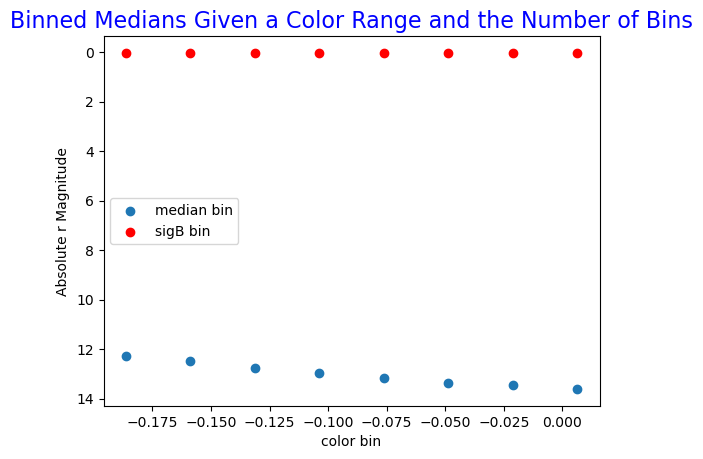

In [67]:
nBins = 8
xBin, medianBin, sigGbin = optimizeDist(df_DC['ri'], df_DC['r_MagAbs'], 
                                        xMin=-0.2, xMax=0.02, nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 3.1101051863140654 7.268988269673737
 best quadratic model: 0.3709375379375363 6.609262162977043
     best cubic model: 0.2704193248336493 8.588185491552991
best 4-th order model: 0.1816415962974179 10.578849304696597
best 5-th order model: 0.18240541991759332 12.659054669996607
best 6-th order model: 0.1824823958487719 14.738573187607622


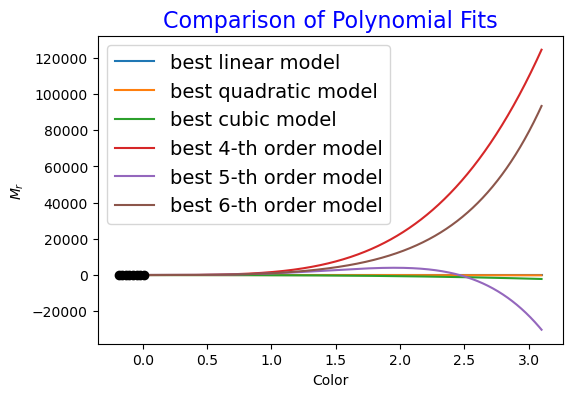

In [68]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are -16.8845, 4.0558, 13.5832 


Text(0.5, 1.0, 'Polynomial Fit of Degree 2 to Data')

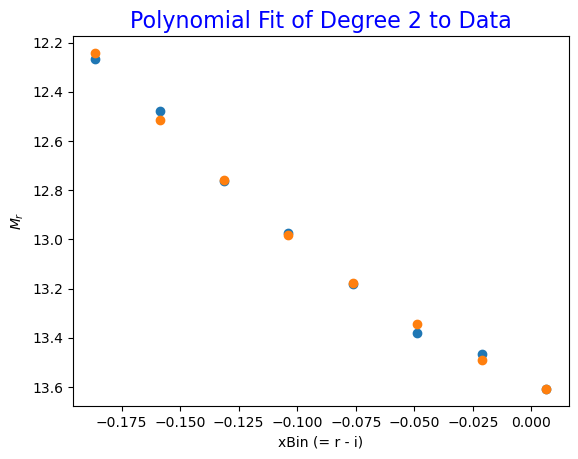

In [69]:
degree = 2
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f, %.4f ' %(z[0], z[1], z[2]))

plt.scatter(xBin, medianBin)
y_value = z[0]*xBin**2 + z[1]*xBin + z[2]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= r - i)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


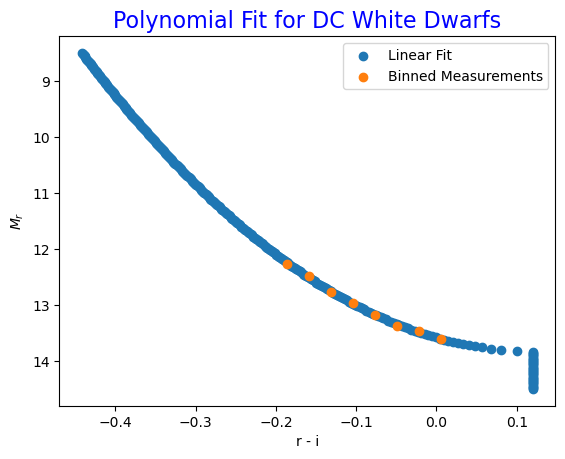

In [70]:
# list of coefficients in descending order of powers
DCri_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1], z[2] - Mr[i]]
#   finding the roots of the cubic equation
    DCri_roots.append(np.roots(z2)[1])
#     print(np.roots(z2)[0])

plt.scatter(DCri_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('r - i')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DC White Dwarfs', fontsize=16, color='blue')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()

#### <span style='color:green'> III.3d DC for i - z

In [71]:
xMin = np.min(df_DC['iz'])
xMax = np.max(df_DC['iz'])
print('xMin, xMax = %.3f, %.3f' %(xMin, xMax))

xMin, xMax = -1.446, 0.110


xBins   medianBin   SigmaGBin     # Pts.  
-0.210      12.44        0.07          37
-0.190      12.68        0.09          58
-0.170      12.96        0.07          53
-0.150      12.79        0.09          43
-0.130      13.18        0.07          44
-0.110      13.26        0.06          48
-0.090      13.58        0.08          43
-0.070      13.64        0.06          28


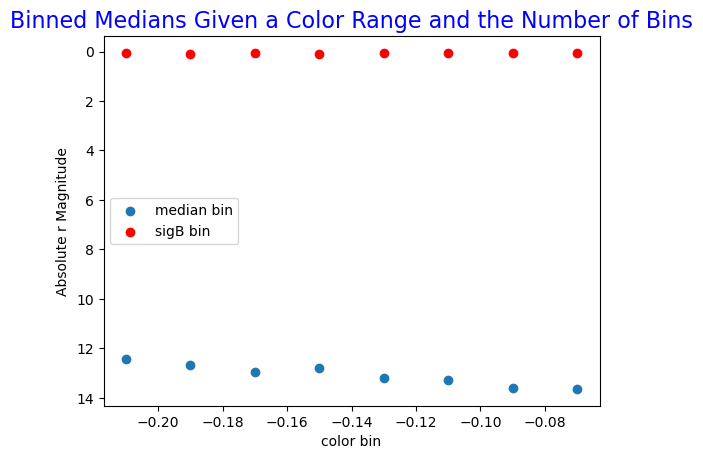

In [72]:
nBins = 8
xBin, medianBin, sigGbin = optimizeDist(df_DC['iz'], df_DC['r_MagAbs'], 
                                        xMin=-0.22, xMax=-0.06, nBins=nBins)


         MODEL             CHI2          BIC
    best linear model: 7.293828913352884 11.452711996712555
 best quadratic model: 7.256220983564169 13.494545608603676
     best cubic model: 7.130421251280907 15.44818741800025
best 4-th order model: 4.8663239044614865 15.263531612860666
best 5-th order model: 4.880646582812079 17.357295832891094
best 6-th order model: 4.88542536234809 19.44151615410694


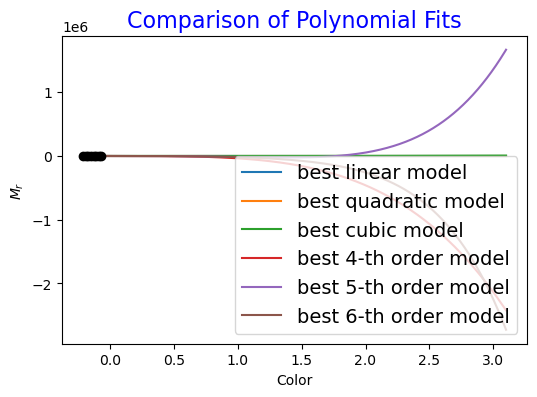

In [73]:
x, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6 = bestFitPlot(xBin, medianBin)
calcBestFit(xBin, medianBin, nBins, sigma_y, theta1, theta2, theta3, theta4, theta5, theta6)


Coefficients of the polynomial fit are 8.4598, 14.2495 


Text(0.5, 1.0, 'Polynomial Fit of Degree 1 to Data')

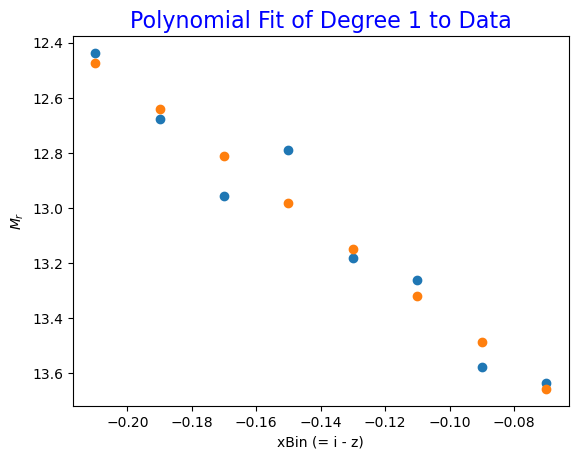

In [74]:
degree = 1
z = np.polyfit(xBin, medianBin, degree)
print('Coefficients of the polynomial fit are %.4f, %.4f ' %(z[0], z[1]))


plt.scatter(xBin, medianBin)
y_value = z[0]*xBin + z[1]
plt.scatter(xBin, y_value)
plt.xlabel('xBin (= i - z)')
plt.ylabel('$M_{r}$')
plt.gca().invert_yaxis()
plt.title('Polynomial Fit of Degree %d to Data' %degree, fontsize=16, color='blue')



('fontsize=16,', "color='blue'")

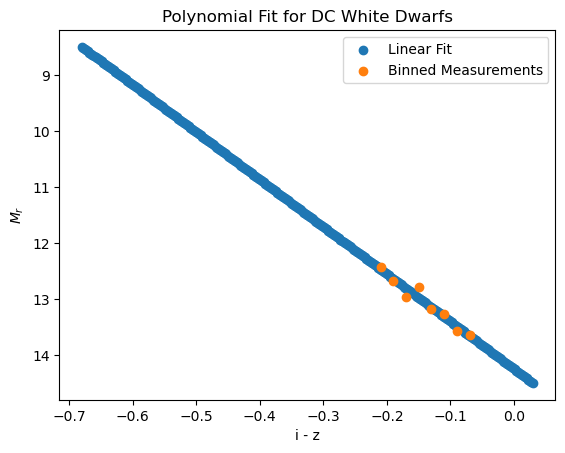

In [75]:
# list of coefficients in descending order of powers
DCiz_roots = []
for i in range(len(Mr)):
    z2 = [z[0], z[1] - Mr[i]]
#   finding the roots of the cubic equation
    DCiz_roots.append(np.roots(z2))
    
plt.scatter(DCiz_roots, Mr, label='Linear Fit')
plt.scatter(xBin, medianBin, label='Binned Measurements')
plt.xlabel('i - z')
plt.ylabel('$M_{r}$')
plt.title('Polynomial Fit for DC White Dwarfs')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()
, fontsize=16, color='blue'

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0.5, 1.0, 'Color Magnitude Fits for DC White Dwarfs')

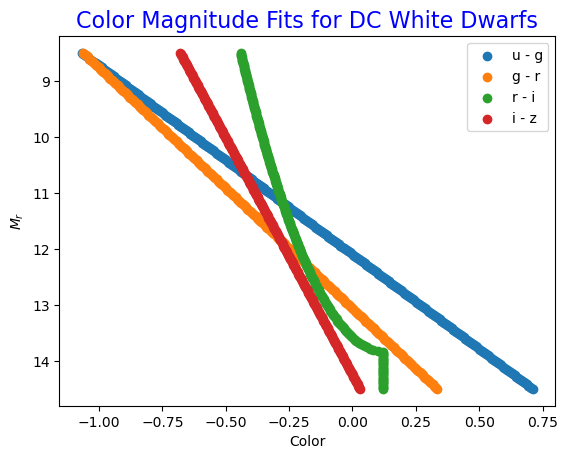

In [76]:
plt.scatter(DCug_roots, Mr, label='u - g')
plt.scatter(DCgr_roots, Mr, label='g - r')
plt.scatter(DCri_roots, Mr, label='r - i')
plt.scatter(DCiz_roots, Mr, label='i - z')
plt.gca().invert_yaxis()
plt.xlabel('Color')
plt.ylabel('$M_{r}$')
plt.legend()
plt.title('Color Magnitude Fits for DC White Dwarfs', fontsize=16, color='blue')

In [77]:
df_DA.columns

Index(['Unnamed: 0', 'level_0', 'index', 'GaiaEDR3', 'RA_ICRS', 'DE_ICRS',
       'Plx', 'Pwd', 'PM', 'pmRA', 'pmDE', 'Gmag', 'BPmag', 'RPmag', 'TeffH',
       'e_TeffH', 'loggH', 'e_loggH', 'MassH', 'TeffHe', 'e_TeffHe', 'loggHe',
       'e_loggHe', 'MassHe', 'Teffmix', 'e_Teffmix', 'loggmix', 'e_loggmix',
       'rgeo', 'b_rgeo', 'B_rgeo', 'rpgeo', 'b_rpgeo', 'B_rpgeo', 'SDSS12',
       'umag', 'gmag', 'rmag', 'imag', 'zmag', 'recno', 'spectype', 'l', 'b',
       'ebv', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z', 'ug',
       'gr', 'ri', 'iz', 'gi', 'rz', 'u_MagAbs', 'g_MagAbs', 'r_MagAbs',
       'i_MagAbs', 'z_MagAbs'],
      dtype='object')

## Make a new pandas DataFrame containing Mr = 8.5, 8.5, 8.6, ... 14.5 and the color fits for WD's and M Dwarfs.
### First the White Dwarfs:

In [78]:
df_WD = pd.DataFrame()

In [79]:
df_WD['Mr'] = Mr
df_WD['DAug'] = np.real(DAug_roots)
df_WD['DAgr'] = np.real(DAgr_roots)
df_WD['DAri'] = np.real(DAri_roots)
df_WD['DAiz'] = np.real(DAiz_roots)

df_WD['DBug'] = np.real(DBug_roots)
df_WD['DBgr'] = np.real(DBgr_roots)
df_WD['DBri'] = np.real(DBri_roots)
df_WD['DBiz'] = np.real(DBiz_roots)

df_WD['DCug'] = np.real(DCug_roots)
df_WD['DCgr'] = np.real(DCgr_roots)
df_WD['DCri'] = np.real(DCri_roots)
df_WD['DCiz'] = np.real(DCiz_roots)


### <span style="color:blue">VI. Save the Output File.</span>
<span style="color:blue">WDMD.csv has the processed white dwarf data and will subsequently be used in model_WDMDs.ipynb to calculate $M_{r}$ and colors for White Dwarf/M Dwarf binary systems.</span>


In [80]:
len(df_WD)

301

In [81]:
df_WD.to_csv('WD.csv', index=False)